# Drive Linking
Linking Google Drive to Colab to enable loading data from the cloud.

In [ ]:
from google.colab import drive                                                  # Imports the Google Colab Drive module

drive.mount('/content/drive')                                                   # Base address of the drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Library Import
Importing all necessary libraries and modules.

In [ ]:
import sys

# Install googletrans if not already installed
if 'googletrans' not in sys.modules:
    !pip install googletrans==4.0.0-rc1

# Install langdetect if not already installed
if 'langdetect' not in sys.modules:
    !pip install langdetect

# Install d2l if not already installed
if 'd2l' not in sys.modules:
    !pip install d2l

# Install nltk if not already installed
if 'nltk' not in sys.modules:
    !pip install nltk

# Install torch-summary if not already installed
if 'torch-summary' not in sys.modules:
    !pip install torch-summary

  Using cached torch_summary-1.4.5-py3-none-any.whl (16 kB)


In [ ]:
# Libraries for data manipulation
import pandas as pd
import numpy as np
import scipy.io as sio  # For working with MATLAB files

# Libraries for natural language processing (NLP)
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from googletrans import Translator  # For translation
from langdetect import detect, LangDetectException  # For language detection

# Libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import tensorflow as tf
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, TFDistilBertForSequenceClassification
from transformers.optimization_tf import AdamWeightDecay

# Libraries for parallel processing
import os
import multiprocessing

# Libraries for neural network management
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss

# Other supporting libraries
from tqdm import tqdm  # For progress bar
import d2l  # Deep Learning 2.0, a library for deeper understanding of machine learning
import time  # For time management

# Libraries for data serialization and manipulation
import json
import base64
import io

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Text processing utilities
import re

# Additional libraries
from torchsummary import summary

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Check Device
Checking the availability of Google GPUs.

In [ ]:
# Set the device for running the model on GPU if available, otherwise use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print("Version: " + str(torch.__version__))
print("Avaible?: " + str(torch.cuda.is_available()))
print("Device: " + str(torch.cuda.get_device_name(0)))
print("Run GPU?: " + str(device))

Version: 2.3.0+cu121
Avaible?: True
Device: Tesla T4
Run GPU?: cuda:0


# Path
Paths to content on Google Drive.

In [ ]:
DATA_PATH = '/content/drive/MyDrive/CCS/Dataset'
DATASET_PATH = DATA_PATH + '/enron_spam_data.csv'
DATASET_CLEAR_PATH = DATA_PATH + '/enron_spam_data_clear.csv'
TRAIN_PATH = DATA_PATH + '/train.csv'
VAL_PATH = DATA_PATH + '/val.csv'
TEST_PATH = DATA_PATH + '/test.csv'
WEIGHTS_PATH = DATA_PATH + '/Weights'
TRAIN_FINAL_PATH = DATA_PATH + '/train_final.csv'
BEST_WEIGHT_PATH = WEIGHTS_PATH + '/Best_Weight'
MODEL_PATH = DATA_PATH + '/Model'

# Data Visualization & Pre-Processing
This code section prepares text data by reading a CSV file, converting 'Spam/Ham' labels to binary format, merging 'Subject' and 'Message' into a unified 'Text' column, and reorganizing columns for clarity. It then handles missing values, prints message counts per label, and applies preprocessing steps like English translation, text cleaning, tokenization, stopword removal, and lemmatization to enhance data quality for analysis and modeling.

In [15]:
# Read the CSV file and ensure it contains 'text' and 'label' columns
df = pd.read_csv(DATASET_PATH)

# Reconfigure the 'Spam/Ham' column to 1 for 'spam' and 0 for 'ham'
df['Spam/Ham'] = df['Spam/Ham'].map({'spam': 1, 'ham': 0})

# Merge the 'Subject' and 'Message' columns into a new column named 'Text'
df['Text'] = df['Subject'] + ' ' + df['Message']

# Remove the specified columns
df = df.drop(columns=['Date', 'Subject', 'Message', 'Message ID'])

# Arrange the columns: 'Message ID', 'Text', 'Spam/Ham'
df = df[['Text', 'Spam/Ham']]

**Data visualization and analysis**
1. Counting the number of messages for each label to determine if the dataset is balanced or not.
2. Identifying missing values present within the instances.
3. Counting and calculating the percentage of missing values for each of the involved classes (Spam and Ham).
4. Analyzing instances with missing values to determine if they are present in Subject, Text, or both.

In [17]:
# Print the total number of messages for each label
total_per_label = df['Spam/Ham'].value_counts()
print("\nTotal number of messages for each label:")
for label, total in total_per_label.items():
    print(f"Label {label}: {total} messages")

# Identify missing values for each row
missing_values = df.isnull()

# Count missing values for each label
missing_per_label = {}
total_per_label = df['Spam/Ham'].value_counts()
for label in df['Spam/Ham'].unique():
    missing_in_label = missing_values[df['Spam/Ham'] == label]
    missing_per_label[label] = missing_in_label.sum()

# Calculate percentage of missing values for each label
percent_missing_per_label = {label: (counts / total_per_label[label] * 100) for label, counts in missing_per_label.items()}

# Print missing values information for each label
print("Missing values per label and percentage:")
for label, counts in missing_per_label.items():
    print(f"\nLabel {label}:")
    perc = percent_missing_per_label[label]
    print(counts)
    print(f"\nPercentage of missing values for label {label}:")
    print(percent_missing_per_label[label])

# Check if rows missing 'Text' also miss 'Body'
missing_subject_and_body = df[missing_values['Text']]

# Count how many messages are label 0 and how many are 1
missing_subject_and_body_per_label = missing_subject_and_body['Spam/Ham'].value_counts()


Total number of messages for each label:
Label 1: 17171 messages
Label 0: 16545 messages
Missing values per label and percentage:

Label 0:
Text        52
Spam/Ham     0
dtype: int64

Percentage of missing values for label 0:
Text        0.314294
Spam/Ham    0.000000
dtype: float64

Label 1:
Text        557
Spam/Ham      0
dtype: int64

Percentage of missing values for label 1:
Text        3.243841
Spam/Ham    0.000000
dtype: float64


In [ ]:
# Delete rows containing missing values
df.dropna(subset=['Text'], inplace=True)

**Data pre-processing**
1. Definition of a function for converting text from any language to English.
2. Definition of a lemmatization function.
3. Definition of a text processing function:
   * Conversion of text to English.
   * Removal of irrelevant elements for classification purposes (e.g., articles, conjunctions, ...).
   * Tokenization of the text to obtain tokens that will be input to the network.
   * Removal of stopwords.
   * Lemmatization.

In [ ]:
def translate_to_english(text):
    """
    Translates text to English using Google Translate if it's detected as non-English.

    Parameters:
    - text (str): The input text to translate.

    Returns:
    - str: Translated text in English if translation succeeds, otherwise returns the original text.
    """
    try:
        detected_lang = detect(text)
        if detected_lang == 'en':
            return text
    except LangDetectException as e:
        print(f"Error detecting language: {e}")
        return text  # If language detection fails, consider the text as already in English

    translator = Translator()
    chunk_size = 500  # Define the chunk size
    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]  # Split text into chunks
    translated_chunks = []

    try:
        for chunk in chunks:
            translated_chunk = translator.translate(chunk, src='auto', dest='en').text
            translated_chunks.append(translated_chunk)
        translated_text = ' '.join(translated_chunks)  # Concatenate translated chunks
        return translated_text
    except Exception as e:
        print(f"Translation failed for text: {text}. Error: {e}")
        return text  # If translation fails, return the original text


def get_wordnet_pos(word):
    """
    Maps POS tags to WordNet POS tags for lemmatization.

    Parameters:
    - word (str): Input word to determine its POS tag.

    Returns:
    - str: WordNet POS tag corresponding to the input word's POS tag.
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)


def preprocess_text(text):
    """
    Preprocesses text by translating to English, cleaning, tokenizing, removing stopwords,
    and lemmatizing.

    Parameters:
    - text (str): The input text to preprocess.

    Returns:
    - str: Processed text after translation, cleaning, tokenization, stopword removal, and lemmatization.
    """
    translated_text = translate_to_english(text)
    clean_text = re.sub(r'[^\w\s]', '', translated_text)
    clean_text = re.sub(r'\b(in|the|all|for|and|on)\b', '_connector_', clean_text)

    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    tokens = tokenizer.tokenize(clean_text)

    stop_words = set(stopwords.words('english'))

    # Removing stop words without tqdm
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_tokens]

    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [ ]:
# Apply transformations to the 'Text' column
df['Text'] = df['Text'].apply(preprocess_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Error detecting language: No features in text.
Error detecting language: No features in text.
Error detecting language: No features in text.


In [ ]:
# Save the modified DataFrame to a new CSV file
df.to_csv(DATASET_CLEAR_PATH, index=False)

# Stratified Splitting
Managing and organizing directories for training and validation. Using a stratified split to ensuring a balanced distribution of classes. These functions ensure that the dataset is divided efficiently and balanced, optimizing data preparation for training and validation.

In [ ]:
# Load your CSV into a pandas DataFrame
df = pd.read_csv(DATASET_CLEAR_PATH)

To split the data into training (65%), validation (15%), and test (20%) sets in a stratified manner using the train_test_split function, you can follow these steps:
*   First, split the data into a training set (65%) and a remaining set (35%).
*   Then, split the remaining set (35%) into validation (15%) and test (20%) sets.

In [ ]:
# Assume that 'colonna_target' is your target variable
X = df.drop('Spam/Ham', axis=1)
y = df['Spam/Ham']

# Split the data into training set and other data (validation + test)
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)

# Further split X_other and y_other into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=(0.2/0.35), stratify=y_other, random_state=42)

Saving the three datasets obtained into three CSV files

In [ ]:
# Save the training set to a CSV file
train = pd.concat([X_train, y_train], axis=1)
train.to_csv(TRAIN_PATH, index=False)

# Save the validation set to a CSV file
val = pd.concat([X_val, y_val], axis=1)
val.to_csv(VAL_PATH, index=False)

# Save the test set to a CSV file
test = pd.concat([X_test, y_test], axis=1)
test.to_csv(TEST_PATH, index=False)

In [ ]:
train_data = pd.read_csv(TRAIN_PATH)
val_data = pd.read_csv(VAL_PATH)
test_data = pd.read_csv(TEST_PATH)

Displaying the training data

In [ ]:
train_data

,Text,Spam/Ham
0,ad _ connector _ felt stiff ##en _ connector _...,1
1,wait _ connector _ name early ##lar ##ena age ...,1
2,waste money buying e usa 8 op 03 ##5 4 wo 5 ##...,1
3,software 3000 shatter hello get thousand softw...,1
4,vale ##ro meter treat sep ##erate ##ly ticket ...,0
...,...,...
21514,mark palmer ask forward per mark palmer instru...,0
21515,_ connector _ _ connector _ top page google gu...,1
21516,_ connector _ best sa 7 _ 0 ##d erin ##g ##l #...,1
21517,color cop ##ier hello l ##yn certainly hope en...,0


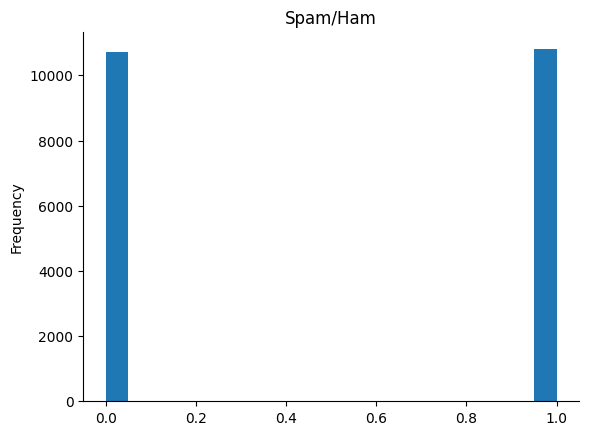

In [ ]:
train_data['Spam/Ham'].plot(kind='hist', bins=20, title='Spam/Ham')
plt.gca().spines[['top', 'right',]].set_visible(False)

Displaying the validation data

In [ ]:
val_data

,Text,Spam/Ham
0,new power ##mo ##d 97 xl ##s marty absolutely ...,0
1,start date 1 15 02 hour ##ah ##ead hour 2 star...,0
2,spa ##m mail warn notification attachment remo...,1
3,computer file protection dear hulk ##j ##r wan...,1
4,confirmation order automatic confirmation _ co...,0
...,...,...
4961,hp ##l expense contract f ##yi call question t...,0
4962,urgent please dr dan nk ##anga zenith internat...,1
4963,cheap online tablet shu ##nt willow ##y ti ##t...,1
4964,interview schedule _ connector _ greg mi ##kk ...,0


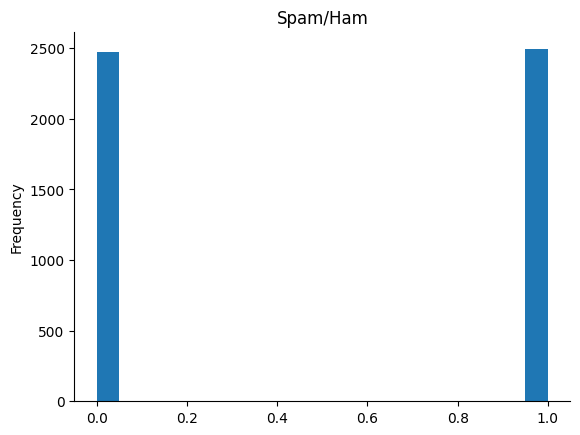

In [ ]:
val_data['Spam/Ham'].plot(kind='hist', bins=20, title='Spam/Ham')
plt.gca().spines[['top', 'right',]].set_visible(False)

Displaying the test data

In [ ]:
test_data

,Text,Spam/Ham
0,rag hard erection formula herbal alternative _...,1
1,brent note sally rough draft note visit yester...,0
2,commodity logic leslie reef work _ connector _...,0
3,start date 1 14 02 hour ##ah ##ead hour 13 sta...,0
4,cheap pharmacy rc would like cheap overseas dr...,1
...,...,...
6617,98 63 ##7 ##3 go 98 63 ##7 ##3 sit ##ara deal ...,0
6618,inn ##ume ##rable 88 vic ##od ##in professor g...,1
6619,ad ##b proposal zu ##ma chris 20 ##a crescent ...,1
6620,f ##w status plan revision hi louise attach sc...,0


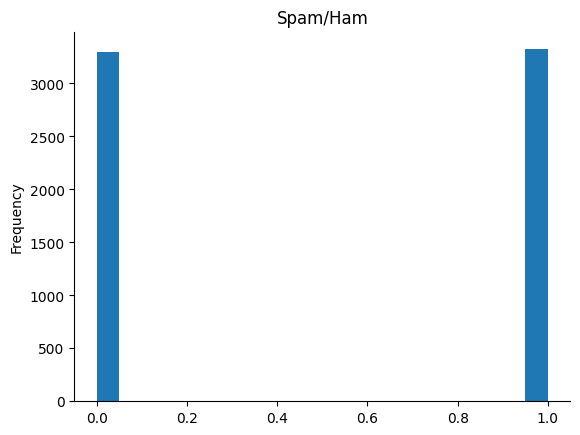

In [ ]:
test_data['Spam/Ham'].plot(kind='hist', bins=20, title='Spam/Ham')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Model Definition
Loading the DistilBERT model for sequence classification, a distilled version of BERT widely used in natural language processing tasks, was chosen for its reduced size, which leads to shorter training times without compromising performance. The model preparation involves replacing the classification layer (Linear) with a sequence comprising a ReLU activation layer, a Dropout layer, and a linear layer. Additionally, the training of the network's feature extraction layers is frozen to retain the pre-trained weights and focus on fine-tuning the classification task.

In [ ]:
model_name = 'distilbert-base-uncased'
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Replace the last layer for binary classification
num_ftrs = model.classifier.out_features                                        # Number of output features from the penultimate layer
# Replace the classifier layer
model.classifier = nn.Sequential( nn.ReLU(),
                                  nn.Dropout(0.2),
                                  nn.Linear(model.classifier.in_features, 2).to(device),
                                  nn.Softmax(dim=1)
                                  )
# Freeze all layers except the classifier layer
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

In [ ]:
def get_vocab_from_model(model_name):
    """
    Retrieve the vocabulary from a specified DistilBERT model.

    Parameters:
    model_name (str): The name or path of the pre-trained DistilBERT model to load the tokenizer from.

    Returns:
    dict: A dictionary representing the vocabulary of the tokenizer, where keys are tokens and values are their corresponding IDs.
    """

    # Initialize the tokenizer using the specified model name
    tokenizer = DistilBertTokenizer.from_pretrained(model_name) #ritorno la maschera di attenzione per dire alla rete dove focalizzarsi e dove no (utile perchè ho del padding)
    # Return the vocabulary associated with the tokenizer
    return tokenizer.get_vocab()

In [ ]:
# Retrieve the vocabulary from the model specified by model_name
vocab = get_vocab_from_model(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Display the summary
batch_size = 512
max_len = 128

summary(model, input_size=(max_len,), depth=1, batch_dim=0, dtypes=['torch.IntTensor'])

Layer (type:depth-idx)                   Param #
├─DistilBertModel: 1-1                   (66,362,880)
├─Linear: 1-2                            590,592
├─Sequential: 1-3                        1,538
├─Dropout: 1-4                           --
Total params: 66,955,010
Trainable params: 592,130
Non-trainable params: 66,362,880


Layer (type:depth-idx)                   Param #
├─DistilBertModel: 1-1                   (66,362,880)
├─Linear: 1-2                            590,592
├─Sequential: 1-3                        1,538
├─Dropout: 1-4                           --
Total params: 66,955,010
Trainable params: 592,130
Non-trainable params: 66,362,880

# Data Loader (Train and Validation)
Setting the batch size and defining the custom class `DistilBERTDataset`, which handles tokenizing text data, padding, truncating, and converting tokens to their respective IDs. It also manages the labels and ensures the input tensors have the correct length by adding padding where necessary. For efficient processing, the `DistilBERTDataset` class uses multiprocessing for token preprocessing. The dataset is created by reading from CSV files containing the training and validation data. For both sets, text is tokenized using the DistilBERT tokenizer, and sentences are preprocessed to ensure they fit the required maximum length. Finally, DataLoaders for both the training and validation sets are created to load data in batches, enabling shuffling and using multiple processes for efficient loading.



In [ ]:
class DistilBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_len, model_name):
        # Initialize the tokenizer using the specified model name
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)

        # Fill any missing text values with an empty string and convert all text data to string type
        dataframe['Text'] = dataframe['Text'].fillna('').astype(str)

        # Extract sentences and labels from the dataframe
        sentences = dataframe['Text']
        labels = dataframe['Spam/Ham']

        # Tokenize each sentence
        all_tokens = [self.tokenizer.tokenize(s) for s in sentences]

        # Convert labels to a torch tensor with long data type
        self.labels = torch.tensor(labels.values, dtype=torch.long)
        self.max_len = max_len

        # Preprocess tokens to convert them to token IDs and obtain valid lengths
        self.all_token_ids, self.valid_lens = self._preprocess(all_tokens)
        print('Read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_tokens):
        # Use multiprocessing with 4 worker processes for preprocessing tokens
        pool = multiprocessing.Pool(4)
        out = pool.map(self._mp_worker, all_tokens)

        # Separate token IDs and valid lengths from the output
        all_token_ids = [token_ids for token_ids, valid_len in out]
        valid_lens = [valid_len for token_ids, valid_len in out]

        # Convert lists to torch tensors
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(valid_lens, dtype=torch.long))

    def _mp_worker(self, tokens):
        # Truncate tokens to fit within the maximum length constraint
        self._truncate_tokens(tokens)

        # Convert tokens to token IDs
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

        # Pad token IDs to the maximum length
        token_ids += [self.tokenizer.pad_token_id] * (self.max_len - len(token_ids))

        # Get the valid length of tokens
        valid_len = len(tokens)

        return token_ids, valid_len

    def _truncate_tokens(self, tokens):
        # Truncate tokens to ensure they fit within the maximum length minus special tokens
        while len(tokens) > self.max_len - 2:
            tokens.pop()

    def __getitem__(self, idx):
        # Return the input tensor, valid length tensor, and label tensor for the given index
        input_tensor = self.all_token_ids[idx]
        valid_len_tensor = self.valid_lens[idx]
        label_tensor = self.labels[idx]
        attention_mask = (input_tensor != self.tokenizer.pad_token_id).long()
        return (input_tensor, valid_len_tensor), attention_mask, label_tensor

    def __len__(self):
        # Return the number of examples in the dataset
        return len(self.all_token_ids)

In [ ]:
# Retrieving the training and validation datasets from the CSV files where they were previously stored
train_data = pd.read_csv(TRAIN_PATH)
val_data = pd.read_csv(VAL_PATH)

In [ ]:
#Loading the datasets using the DataLoader function available for instances of the class defined above

batch_size = 512
max_len = 128

train_set = DistilBERTDataset(train_data, max_len, model_name)
val_set = DistilBERTDataset(val_data, max_len, model_name)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Read 21519 examples


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Read 4966 examples


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True,num_workers=2)

# Training with Validation
This code block sets up and executes a training and validation loop for a machine learning model. The training is organized into epochs, where the model processes batches of training data, computes outputs, calculates loss against true labels, and updates its parameters through backpropagation using an optimizer. After each epoch, the model's performance is evaluated on a validation dataset, where it processes validation data, computes outputs, and measures validation loss and accuracy.

The function tracks the best validation accuracy and loss, saving the model's weights when a new best performance is achieved. It logs the training and validation metrics for each epoch. The function returns the epoch number at which the best model was obtained. The script also sets up device configuration, learning rate, number of epochs, and initializes performance metrics. It uses CrossEntropyLoss as the loss function and AdamW as the optimizer.

In [ ]:
def train_loop_validation(train_dataloader, val_dataloader, startEpoch, numEpochs, model_conv, criterion, optimizer, best_acc, best_loss, best_epoca, outputPath, scheduler=None):
    """
    Function to train and validate a model with given data loaders, criterion, optimizer, and scheduler.

    Parameters:
    - train_dataloader: DataLoader for the training data
    - val_dataloader: DataLoader for the validation data
    - startEpoch: Starting epoch number
    - numEpochs: Total number of epochs to train
    - model_conv: The model to be trained and validated
    - criterion: Loss function
    - optimizer: Optimization algorithm
    - best_acc: Best validation accuracy achieved so far
    - best_loss: Best validation loss achieved so far
    - best_epoca: Epoch at which the best model was obtained
    - outputPath: Directory path to save the training logs and model weights
    - scheduler: Learning rate scheduler (optional)

    Returns:
    - best_epoca: The epoch at which the best model was achieved based on validation accuracy and loss
    """

    train_files = ['lossTrain.txt', 'AccTrain.txt', 'lossVal.txt', 'AccVal.txt']
    for filename in train_files:
        filepath = os.path.join(outputPath, filename)
        if os.path.exists(filepath):
            os.remove(filepath)

    for epoch in range(startEpoch, numEpochs + 1):
        since = time.time()

        modelLoss_train = 0.0
        modelAcc_train = 0.0

        model_conv.train()
        totalSize = 0

        # Training loop
        for batch in tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch}/{numEpochs} - Training"):
            (inputs, valid_lens), attention_mask, labels = batch

            inputs = inputs.to(device)
            valid_lens = valid_lens.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model_conv(inputs, attention_mask=attention_mask)
            logits = outputs.logits  # Access logits from SequenceClassifierOutput
            loss = criterion(logits, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            modelLoss_train += loss.item() * inputs.size(0)
            _, preds = torch.max(logits, 1)
            modelAcc_train += (preds == labels).sum().item()
            totalSize += inputs.size(0)

        epoch_loss = modelLoss_train / totalSize
        epoch_acc = modelAcc_train / totalSize

        # Validation loop
        model_conv.eval()
        modelLoss_val = 0.0
        modelAcc_val = 0.0
        totalSize_val = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, total=len(val_dataloader), desc=f"Epoch {epoch}/{numEpochs} - Validation"):
                (inputs, valid_lens), attention_mask, labels = batch

                inputs = inputs.to(device)
                valid_lens = valid_lens.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)  # No need for .view(-1, 1) and .float()

                outputs = model_conv(inputs, attention_mask=attention_mask)
                logits = outputs.logits  # Access logits from SequenceClassifierOutput
                loss = criterion(logits, labels)

                modelLoss_val += loss.item() * inputs.size(0)
                _, preds = torch.max(logits, 1)
                modelAcc_val += (preds == labels).sum().item()
                totalSize_val += inputs.size(0)

        val_loss = modelLoss_val / totalSize_val
        val_acc = modelAcc_val / totalSize_val

        time_elapsed = time.time() - since
        current_lr = optimizer.param_groups[0]['lr']

        print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][VAL on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s] [LR: %.5f]'
              % (epoch, totalSize, epoch_loss, epoch_acc, totalSize_val, val_loss, val_acc, time_elapsed // 60, time_elapsed % 60, current_lr))

        if val_acc > best_acc or (val_acc == best_acc and val_loss < best_loss):
            best_acc = val_acc
            best_loss = val_loss
            best_epoca = epoch
            print('     .... Saving best weights ....')
            torch.save(model_conv.state_dict(), os.path.join(outputPath, 'best_model_weights.pth'))

        with open(os.path.join(outputPath, 'lossTrain.txt'), 'a') as f:
            f.write(f'{epoch_loss}\n')
        with open(os.path.join(outputPath, 'AccTrain.txt'), 'a') as f:
            f.write(f'{epoch_acc}\n')
        with open(os.path.join(outputPath, 'lossVal.txt'), 'a') as f:
            f.write(f'{val_loss}\n')
        with open(os.path.join(outputPath, 'AccVal.txt'), 'a') as f:
            f.write(f'{val_acc}\n')

        if scheduler:
            scheduler.step(val_loss)

    return best_epoca

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #vedo se la GPU è disponibile

In [ ]:
# Updated hyperparameters
learning_rate = 0.00085                                                         # Learning rate for the optimizer
num_epochs = 45                                                                 # Total number of epochs for training
startEpoch = 1                                                                  # Initial epoch (useful for resuming interrupted training)
best_acc = 0.0                                                                  # Initial best accuracy (to track the best model)
best_loss = float('inf')                                                        # Initial best loss (to track the best model)
best_epoch = -1                                                                 # Epoch corresponding to the best saved model

**Model Preparation for Training**

1. Choice of the loss function (CrossEntropy) and optimizer (AdamW)

In [ ]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss().to(device) #scelgo come loss function la CrossEntropy()
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False) #scelgo AdamW come ottimizzatore

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Call the training function with validation
best_epoch = train_loop_validation(train_dataloader, val_dataloader, startEpoch, num_epochs, model, criterion, optimizer, best_acc, best_loss, best_epoch, WEIGHTS_PATH)

Epoch 1/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


[Epoch 1][TRAIN on 21519 [Loss: 0.4968  ACC: 0.8036]][VAL on 4966 [Loss: 0.4198  ACC: 0.8870]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 2/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


[Epoch 2][TRAIN on 21519 [Loss: 0.4159  ACC: 0.8937]][VAL on 4966 [Loss: 0.3962  ACC: 0.9140]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 3/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Epoch 3][TRAIN on 21519 [Loss: 0.4096  ACC: 0.9000]][VAL on 4966 [Loss: 0.3970  ACC: 0.9106]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 4/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Epoch 4][TRAIN on 21519 [Loss: 0.4072  ACC: 0.9022]][VAL on 4966 [Loss: 0.3872  ACC: 0.9229]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 5/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 5][TRAIN on 21519 [Loss: 0.4043  ACC: 0.9052]][VAL on 4966 [Loss: 0.3858  ACC: 0.9223]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 6/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Epoch 6][TRAIN on 21519 [Loss: 0.4011  ACC: 0.9085]][VAL on 4966 [Loss: 0.3819  ACC: 0.9291]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 7/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Epoch 7][TRAIN on 21519 [Loss: 0.3966  ACC: 0.9145]][VAL on 4966 [Loss: 0.3802  ACC: 0.9305]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 8/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 8][TRAIN on 21519 [Loss: 0.3931  ACC: 0.9174]][VAL on 4966 [Loss: 0.3815  ACC: 0.9301]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 9/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Epoch 9][TRAIN on 21519 [Loss: 0.3964  ACC: 0.9127]][VAL on 4966 [Loss: 0.3875  ACC: 0.9231]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 10/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 10][TRAIN on 21519 [Loss: 0.4036  ACC: 0.9057]][VAL on 4966 [Loss: 0.4064  ACC: 0.9007]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 11/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 11][TRAIN on 21519 [Loss: 0.3991  ACC: 0.9109]][VAL on 4966 [Loss: 0.3891  ACC: 0.9205]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 12/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 12][TRAIN on 21519 [Loss: 0.3936  ACC: 0.9174]][VAL on 4966 [Loss: 0.3845  ACC: 0.9251]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 13/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 13][TRAIN on 21519 [Loss: 0.3905  ACC: 0.9201]][VAL on 4966 [Loss: 0.3785  ACC: 0.9303]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 14/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 14][TRAIN on 21519 [Loss: 0.3896  ACC: 0.9201]][VAL on 4966 [Loss: 0.3869  ACC: 0.9237]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 15/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 15][TRAIN on 21519 [Loss: 0.3893  ACC: 0.9206]][VAL on 4966 [Loss: 0.3810  ACC: 0.9301]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 16/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 16][TRAIN on 21519 [Loss: 0.3887  ACC: 0.9221]][VAL on 4966 [Loss: 0.3755  ACC: 0.9337]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 17/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 17][TRAIN on 21519 [Loss: 0.3901  ACC: 0.9210]][VAL on 4966 [Loss: 0.3773  ACC: 0.9317]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 18/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Epoch 18][TRAIN on 21519 [Loss: 0.3914  ACC: 0.9180]][VAL on 4966 [Loss: 0.3749  ACC: 0.9356]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 19/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Epoch 19][TRAIN on 21519 [Loss: 0.3856  ACC: 0.9263]][VAL on 4966 [Loss: 0.3759  ACC: 0.9323]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 20/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Epoch 20][TRAIN on 21519 [Loss: 0.3840  ACC: 0.9262]][VAL on 4966 [Loss: 0.3732  ACC: 0.9364]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 21/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Epoch 21][TRAIN on 21519 [Loss: 0.3858  ACC: 0.9250]][VAL on 4966 [Loss: 0.3745  ACC: 0.9340]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 22/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 22][TRAIN on 21519 [Loss: 0.3855  ACC: 0.9246]][VAL on 4966 [Loss: 0.3920  ACC: 0.9166]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 23/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 23][TRAIN on 21519 [Loss: 0.3905  ACC: 0.9193]][VAL on 4966 [Loss: 0.3737  ACC: 0.9350]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 24/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Epoch 24][TRAIN on 21519 [Loss: 0.3847  ACC: 0.9263]][VAL on 4966 [Loss: 0.3829  ACC: 0.9271]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 25/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 25][TRAIN on 21519 [Loss: 0.3821  ACC: 0.9292]][VAL on 4966 [Loss: 0.3746  ACC: 0.9364]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 26/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 26][TRAIN on 21519 [Loss: 0.3836  ACC: 0.9263]][VAL on 4966 [Loss: 0.3716  ACC: 0.9394]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 27/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 27][TRAIN on 21519 [Loss: 0.3819  ACC: 0.9291]][VAL on 4966 [Loss: 0.3721  ACC: 0.9382]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 28/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Epoch 28][TRAIN on 21519 [Loss: 0.3799  ACC: 0.9313]][VAL on 4966 [Loss: 0.3811  ACC: 0.9281]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 29/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Epoch 29][TRAIN on 21519 [Loss: 0.3791  ACC: 0.9324]][VAL on 4966 [Loss: 0.3700  ACC: 0.9402]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 30/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


[Epoch 30][TRAIN on 21519 [Loss: 0.3783  ACC: 0.9336]][VAL on 4966 [Loss: 0.3684  ACC: 0.9426]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 31/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 31][TRAIN on 21519 [Loss: 0.3776  ACC: 0.9342]][VAL on 4966 [Loss: 0.3679  ACC: 0.9454]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 32/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 32][TRAIN on 21519 [Loss: 0.3804  ACC: 0.9306]][VAL on 4966 [Loss: 0.3666  ACC: 0.9452]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 33/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 33][TRAIN on 21519 [Loss: 0.3762  ACC: 0.9362]][VAL on 4966 [Loss: 0.3662  ACC: 0.9460]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 34/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 34][TRAIN on 21519 [Loss: 0.3768  ACC: 0.9348]][VAL on 4966 [Loss: 0.3789  ACC: 0.9311]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 35/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 35][TRAIN on 21519 [Loss: 0.3791  ACC: 0.9314]][VAL on 4966 [Loss: 0.3705  ACC: 0.9412]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 36/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 36][TRAIN on 21519 [Loss: 0.3810  ACC: 0.9293]][VAL on 4966 [Loss: 0.3662  ACC: 0.9462]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 37/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 37][TRAIN on 21519 [Loss: 0.3753  ACC: 0.9364]][VAL on 4966 [Loss: 0.3777  ACC: 0.9315]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 38/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 38][TRAIN on 21519 [Loss: 0.3795  ACC: 0.9320]][VAL on 4966 [Loss: 0.3671  ACC: 0.9432]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 39/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 39][TRAIN on 21519 [Loss: 0.3733  ACC: 0.9386]][VAL on 4966 [Loss: 0.3649  ACC: 0.9474]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


Epoch 40/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 40][TRAIN on 21519 [Loss: 0.3749  ACC: 0.9372]][VAL on 4966 [Loss: 0.3699  ACC: 0.9400]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 41/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 41][TRAIN on 21519 [Loss: 0.3751  ACC: 0.9365]][VAL on 4966 [Loss: 0.3641  ACC: 0.9470]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 42/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 42][TRAIN on 21519 [Loss: 0.3785  ACC: 0.9331]][VAL on 4966 [Loss: 0.3669  ACC: 0.9428]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 43/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


[Epoch 43][TRAIN on 21519 [Loss: 0.3749  ACC: 0.9369]][VAL on 4966 [Loss: 0.3651  ACC: 0.9448]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 44/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 44][TRAIN on 21519 [Loss: 0.3742  ACC: 0.9379]][VAL on 4966 [Loss: 0.3666  ACC: 0.9452]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 45/45 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Epoch 45][TRAIN on 21519 [Loss: 0.3776  ACC: 0.9350]][VAL on 4966 [Loss: 0.3640  ACC: 0.9489]][TIME: 1 m 30 s] [LR: 0.00085]
     .... Saving best weights ....


# Metrics Plot
Visualization and analysis of performance metrics obtained during the training and validation process.
Loss and accuracy values are read from previously saved text files, and the values are plotted in two separate graphs: one for loss and the other for accuracy. This section allows for the selection of hyperparameters for the subsequent final training.

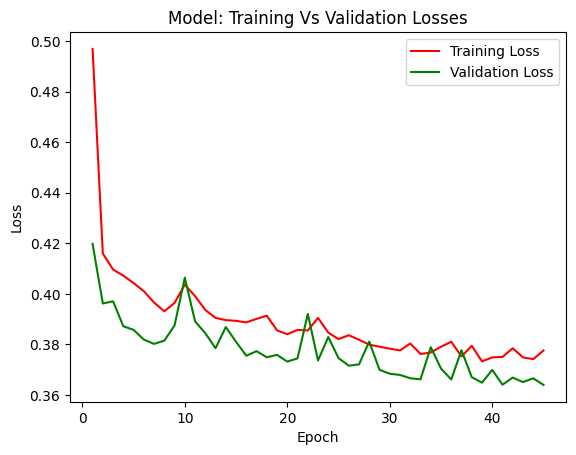

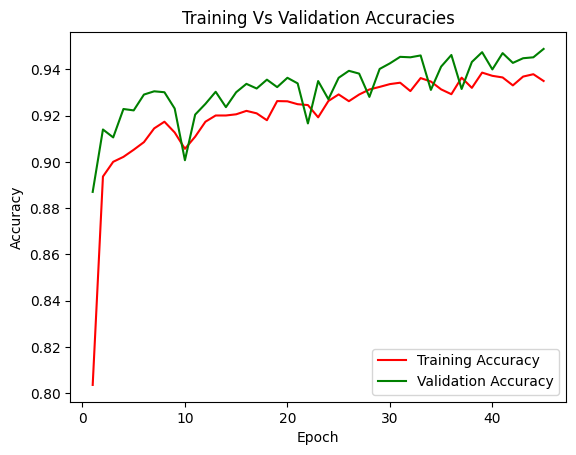

In [ ]:
# Initialization of lists for losses and accuracies
loss_model_train = []
loss_model_val = []
acc_model_train = []
acc_model_val = []

# Reading training loss files
loss_train_path = os.path.join(WEIGHTS_PATH, 'lossTrain.txt')
with open(loss_train_path, 'r') as file:
    loss_model_train = [float(line.strip()) for line in file.readlines()]

# Reading validation loss files
loss_val_path = os.path.join(WEIGHTS_PATH, 'lossVal.txt')
with open(loss_val_path, 'r') as file:
    loss_model_val = [float(line.strip()) for line in file.readlines()]

# Plotting training and validation losses
plt.figure()
plt.title("Model: Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, len(loss_model_train) + 1), loss_model_train, color='r', label="Training Loss")
plt.plot(range(1, len(loss_model_val) + 1), loss_model_val, color='g', label="Validation Loss")
plt.legend()
plt.savefig(os.path.join(WEIGHTS_PATH, 'LossTrainVal.png'))

# Reading training accuracy files
acc_train_path = os.path.join(WEIGHTS_PATH, 'AccTrain.txt')
with open(acc_train_path, 'r') as file:
    acc_model_train = [float(line.strip()) for line in file.readlines()]

# Reading validation accuracy files
acc_val_path = os.path.join(WEIGHTS_PATH, 'AccVal.txt')
with open(acc_val_path, 'r') as file:
    acc_model_val = [float(line.strip()) for line in file.readlines()]

# Plotting training and validation accuracies
plt.figure()
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(1, len(acc_model_train) + 1), acc_model_train, color='r', label="Training Accuracy")
plt.plot(range(1, len(acc_model_val) + 1), acc_model_val, color='g', label="Validation Accuracy")
plt.legend()
plt.savefig(os.path.join(WEIGHTS_PATH, 'AccTrainVal.png'))

# DataLoader (Full Dataset)
Applying the DataLoader to the entire dataset without splitting into train and validation.

In [ ]:
class DistilBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_len, model_name):
        # Initialize the tokenizer from the DistilBERT model
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)

        # Fill missing text values with empty strings and ensure all text data is string type
        dataframe['Text'] = dataframe['Text'].fillna('').astype(str)

        # Extract sentences and labels from the dataframe
        sentences = dataframe['Text']
        labels = dataframe['Spam/Ham']

        # Tokenize all sentences
        all_tokens = [self.tokenizer.tokenize(s) for s in sentences]

        # Convert labels to torch tensor
        self.labels = torch.tensor(labels.values, dtype=torch.long)
        self.max_len = max_len

        # Preprocess tokens to convert them to token IDs and get valid lengths
        self.all_token_ids, self.valid_lens = self._preprocess(all_tokens)
        print('Read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_tokens):
        # Use multiprocessing to preprocess tokens with 4 worker processes
        pool = multiprocessing.Pool(4)
        out = pool.map(self._mp_worker, all_tokens)

        # Separate token IDs and valid lengths from the output
        all_token_ids = [token_ids for token_ids, valid_len in out]
        valid_lens = [valid_len for token_ids, valid_len in out]

        # Convert to torch tensors
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(valid_lens, dtype=torch.long))

    def _mp_worker(self, tokens):
        # Truncate tokens to fit the max length constraint
        self._truncate_tokens(tokens)

        # Convert tokens to token IDs
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

        # Pad token IDs to max length
        token_ids += [self.tokenizer.pad_token_id] * (self.max_len - len(token_ids))

        # Get the valid length of tokens
        valid_len = len(tokens)

        return token_ids, valid_len

    def _truncate_tokens(self, tokens):
        # Truncate tokens to leave room for special tokens
        while len(tokens) > self.max_len - 2:
            tokens.pop()

    def __getitem__(self, idx):        # Return the input tensor, valid length tensor, and label tensor for the given index
        input_tensor = self.all_token_ids[idx]
        valid_len_tensor = self.valid_lens[idx]
        label_tensor = self.labels[idx]
        attention_mask = (input_tensor != self.tokenizer.pad_token_id).long()
        return (input_tensor, valid_len_tensor), attention_mask, label_tensor

    def __len__(self):
        # Return the number of examples in the dataset
        return len(self.all_token_ids)

**Dataset Management for Training**

1. Creation of the final training dataset by concatenating the two previously used datasets for training and validation.
2. Saving the new dataset in CSV format.

In [ ]:
# Read data from CSV files
train_data = pd.read_csv(TRAIN_PATH)
val_data = pd.read_csv(VAL_PATH)

# Merge the two DataFrames
combined_data = pd.concat([train_data, val_data], ignore_index=True)

# Shuffle the combined DataFrame
shuffled_data = combined_data.sample(frac=1).reset_index(drop=True)

# Save the combined and shuffled DataFrame to the specified path
shuffled_data.to_csv(TRAIN_FINAL_PATH, index=False)

In [ ]:
batch_size = 512
max_len = 128

# Read the final training data from CSV
final_train_data = pd.read_csv(TRAIN_FINAL_PATH)

# Create a dataset for training using DistilBERTDataset
final_train_set = DistilBERTDataset(final_train_data, max_len, model_name)

# Create a DataLoader for the final training set
final_train_dataloader = torch.utils.data.DataLoader(final_train_set, batch_size, shuffle=True, num_workers=2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Read 26485 examples


# Training (Full Dataset)
Training using the entire available dataset. During training, model loss and accuracy metrics are calculated and monitored. Additionally, model weights are saved after each epoch to allow for resumption and monitoring of training in case of interruptions.

In [ ]:
def train_loop(train_dataloader, startEpoch, numEpochs, model_conv, criterion, optimizer, outputPath, scheduler=None):
    """
    Function to train a PyTorch model using a specified DataLoader for a number of epochs,
    saving training metrics and model weights periodically.

    Parameters:
    - train_dataloader (torch.utils.data.DataLoader): DataLoader containing the training data.
    - startEpoch (int): Starting epoch number for training.
    - numEpochs (int): Total number of epochs to train the model.
    - model_conv (torch.nn.Module): PyTorch model to be trained.
    - criterion: Loss function to calculate the loss.
    - optimizer: Optimization algorithm used for training.
    - outputPath (str): Directory path to save training outputs (losses, accuracies, weights).
    - scheduler (optional): Learning rate scheduler to adjust the learning rate during training.

    Returns:
    - None: Trains the model, saves training metrics and model weights, and prints training progress.
    """

    train_files = ['lossTrain.txt', 'AccTrain.txt']
    for filename in train_files:
        filepath = os.path.join(outputPath, filename)
        if os.path.exists(filepath):
            os.remove(filepath)

    for epoch in range(startEpoch, numEpochs + 1):
        since = time.time()

        modelLoss_train = 0.0
        modelAcc_train = 0.0

        model_conv.train()
        totalSize = 0

        # Training loop
        for batch in tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch}/{numEpochs} - Training"):
            (inputs, valid_lens), attention_mask, labels = batch

            inputs = inputs.to(device)
            valid_lens = valid_lens.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model_conv(inputs, attention_mask=attention_mask)
            logits = outputs.logits                 # Access logits from the SequenceClassifierOutput object
            loss = criterion(logits, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            modelLoss_train += loss.item() * inputs.size(0)
            _, preds = torch.max(logits, 1)
            modelAcc_train += (preds == labels).sum().item()
            totalSize += inputs.size(0)

        epoch_loss = modelLoss_train / totalSize
        epoch_acc = modelAcc_train / totalSize

        time_elapsed = time.time() - since
        current_lr = optimizer.param_groups[0]['lr']

        print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s] [LR: %.5f]'
              % (epoch, totalSize, epoch_loss, epoch_acc, time_elapsed // 60, time_elapsed % 60, current_lr))

        # Save weights after each epoch, overwriting them
        torch.save(model_conv.state_dict(), os.path.join(outputPath, 'weights.pth'))

        with open(os.path.join(outputPath, 'lossTrain.txt'), 'a') as f:
            f.write(f'{epoch_loss}\n')
        with open(os.path.join(outputPath, 'AccTrain.txt'), 'a') as f:
            f.write(f'{epoch_acc}\n')

        if scheduler:
            scheduler.step(epoch_loss)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Updated hyperparameters
learning_rate = 0.00085                                                         # Learning rate for the optimizer
num_epochs = 45                                                                # Total number of epochs for training
startEpoch = 1                                                                  # Initial epoch (useful for resuming interrupted training)
best_acc = 0.0                                                                  # Initial best accuracy (to track the best model)
best_loss = float('inf')                                                        # Initial best loss (to track the best model)
best_epoch = -1                                                                 # Epoch corresponding to the best saved model

**Preparing the model for training**

1. Selection of the loss function (CrossEntropy) and optimizer (AdamW)

In [ ]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)

In [ ]:
# Call the training function
train_loop(final_train_dataloader, startEpoch, num_epochs, model, criterion, optimizer, BEST_WEIGHT_PATH)

Epoch 1/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 1][TRAIN on 26485 [Loss: 0.3843  ACC: 0.9255]][TIME: 1 m 31 s] [LR: 0.00085]


Epoch 2/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 2][TRAIN on 26485 [Loss: 0.3768  ACC: 0.9351]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 3/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 3][TRAIN on 26485 [Loss: 0.3771  ACC: 0.9339]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 4/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 4][TRAIN on 26485 [Loss: 0.3754  ACC: 0.9365]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 5/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 5][TRAIN on 26485 [Loss: 0.3759  ACC: 0.9343]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 6/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 6][TRAIN on 26485 [Loss: 0.3732  ACC: 0.9380]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 7/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 7][TRAIN on 26485 [Loss: 0.3699  ACC: 0.9417]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 8/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 8][TRAIN on 26485 [Loss: 0.3692  ACC: 0.9430]][TIME: 1 m 31 s] [LR: 0.00085]


Epoch 9/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 9][TRAIN on 26485 [Loss: 0.3680  ACC: 0.9436]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 10/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 10][TRAIN on 26485 [Loss: 0.3702  ACC: 0.9409]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 11/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 11][TRAIN on 26485 [Loss: 0.3681  ACC: 0.9440]][TIME: 1 m 31 s] [LR: 0.00085]


Epoch 12/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 12][TRAIN on 26485 [Loss: 0.3699  ACC: 0.9411]][TIME: 1 m 31 s] [LR: 0.00085]


Epoch 13/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 13][TRAIN on 26485 [Loss: 0.3683  ACC: 0.9436]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 14/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 14][TRAIN on 26485 [Loss: 0.3665  ACC: 0.9452]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 15/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 15][TRAIN on 26485 [Loss: 0.3666  ACC: 0.9455]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 16/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 16][TRAIN on 26485 [Loss: 0.3646  ACC: 0.9469]][TIME: 1 m 31 s] [LR: 0.00085]


Epoch 17/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 17][TRAIN on 26485 [Loss: 0.3655  ACC: 0.9468]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 18/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 18][TRAIN on 26485 [Loss: 0.3643  ACC: 0.9474]][TIME: 1 m 31 s] [LR: 0.00085]


Epoch 19/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 19][TRAIN on 26485 [Loss: 0.3657  ACC: 0.9459]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 20/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 20][TRAIN on 26485 [Loss: 0.3644  ACC: 0.9470]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 21/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 21][TRAIN on 26485 [Loss: 0.3641  ACC: 0.9482]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 22/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 22][TRAIN on 26485 [Loss: 0.3650  ACC: 0.9471]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 23/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 23][TRAIN on 26485 [Loss: 0.3639  ACC: 0.9484]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 24/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 24][TRAIN on 26485 [Loss: 0.3636  ACC: 0.9488]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 25/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 25][TRAIN on 26485 [Loss: 0.3621  ACC: 0.9502]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 26/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 26][TRAIN on 26485 [Loss: 0.3629  ACC: 0.9485]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 27/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 27][TRAIN on 26485 [Loss: 0.3622  ACC: 0.9500]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 28/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 28][TRAIN on 26485 [Loss: 0.3622  ACC: 0.9498]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 29/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]


[Epoch 29][TRAIN on 26485 [Loss: 0.3613  ACC: 0.9506]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 30/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 30][TRAIN on 26485 [Loss: 0.3618  ACC: 0.9510]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 31/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 31][TRAIN on 26485 [Loss: 0.3624  ACC: 0.9495]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 32/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 32][TRAIN on 26485 [Loss: 0.3614  ACC: 0.9504]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 33/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 33][TRAIN on 26485 [Loss: 0.3609  ACC: 0.9520]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 34/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 34][TRAIN on 26485 [Loss: 0.3616  ACC: 0.9505]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 35/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 35][TRAIN on 26485 [Loss: 0.3602  ACC: 0.9519]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 36/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 36][TRAIN on 26485 [Loss: 0.3589  ACC: 0.9536]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 37/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 37][TRAIN on 26485 [Loss: 0.3591  ACC: 0.9536]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 38/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 38][TRAIN on 26485 [Loss: 0.3597  ACC: 0.9519]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 39/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 39][TRAIN on 26485 [Loss: 0.3593  ACC: 0.9532]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 40/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 40][TRAIN on 26485 [Loss: 0.3592  ACC: 0.9530]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 41/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 41][TRAIN on 26485 [Loss: 0.3583  ACC: 0.9542]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 42/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 42][TRAIN on 26485 [Loss: 0.3588  ACC: 0.9540]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 43/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 43][TRAIN on 26485 [Loss: 0.3593  ACC: 0.9530]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 44/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 44][TRAIN on 26485 [Loss: 0.3586  ACC: 0.9539]][TIME: 1 m 30 s] [LR: 0.00085]


Epoch 45/45 - Training: 100%|██████████| 52/52 [01:30<00:00,  1.73s/it]


[Epoch 45][TRAIN on 26485 [Loss: 0.3589  ACC: 0.9534]][TIME: 1 m 30 s] [LR: 0.00085]


# Testing
Loading data for testing and evaluating the model with a confusion matrix visualization


In [ ]:
model_name = 'distilbert-base-uncased'
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# Replace the last layer for binary classification
num_ftrs = model.classifier.out_features  # Number of output features from the penultimate layer
# Replace the classifier layer
model.classifier = nn.Sequential( nn.ReLU(),
                                  nn.Dropout(0.2),
                                  nn.Linear(model.classifier.in_features, 2).to(device),
                                  nn.Softmax(dim=1)
                                  )
# Define criterion
criterion = nn.CrossEntropyLoss().to(device)          # Choose CrossEntropy as the loss function

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 512
max_len = 128

test_data = pd.read_csv(TEST_PATH)
test_set = DistilBERTDataset(test_data, max_len, model_name)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True,num_workers=2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Read 6622 examples


In [ ]:
def test_model(model, model_name, test_dataloader, best_weights_path, device):
    """
    Evaluate a PyTorch model on test data and display evaluation metrics.

    Parameters:
    - model (torch.nn.Module): The PyTorch model to evaluate.
    - test_dataloader (torch.utils.data.DataLoader): DataLoader containing the test data.
    - best_weights_path (str): Path to the directory containing the best model weights.
    - device (torch.device): Device on which to perform the evaluation (e.g., 'cuda' or 'cpu').

    Returns:
    - None: Prints accuracy, confusion matrix, and examples of incorrectly classified instances.
    """

    tokenizer = DistilBertTokenizer.from_pretrained(model_name)

    # Load the model weights
    model.load_state_dict(torch.load(best_weights_path + '/weights.pth'))
    model.to(device)  # Ensure the model is on the correct device
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    wrong_pred_ham = []           # List of incorrectly classified ham instances
    wrong_seq_ham = []
    wrong_prob_ham = []
    wrong_pred_spam = []          # List of incorrectly classified spam instances
    wrong_seq_spam = []
    wrong_prob_spam = []

    # Disable gradient calculations for evaluation
    with torch.no_grad():
        for data in test_dataloader:
            inputs, attention_mask, labels = data
            input_ids, valid_lens = inputs
            input_ids, valid_lens, labels = input_ids.to(device), valid_lens.to(device), labels.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    if labels[i] == 0:
                        wrong_pred_ham.append(input_ids[i].cpu().numpy())
                        wrong_seq_ham.append(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[i])))
                        wrong_prob_ham.append(logits[i].cpu().numpy())
                    elif labels[i] == 1:
                        wrong_pred_spam.append(input_ids[i].cpu().numpy())
                        wrong_seq_spam.append(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[i])))
                        wrong_prob_spam.append(logits[i].cpu().numpy())

    # Calculate accuracy metrics
    accuracy = accuracy_score(all_labels, all_preds)

    print(f'Accuracy: {accuracy:.4f}')

    # Calculate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Display the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Display some of the incorrectly classified instances
    print("Wrong predictions, true class HAM:")
    print(f"      -----------------------------------     ")
    for i in range(min(5, len(wrong_pred_ham))):
        print(f"  Wrong prediction {i}: predicted probability  = {wrong_prob_ham[i]}")
        print(f"    input: {wrong_pred_ham[i]}")
        print(f"    original sequence: {wrong_seq_ham[i]}")
        print(f"      -----------------------------------     ")

    print("\nWrong predictions, true class SPAM:")
    print(f"      -----------------------------------     ")
    for i in range(min(5, len(wrong_pred_spam))):
        print(f"  Wrong prediction {i}: predicted probability = {wrong_prob_spam[i]}")
        print(f"    input: {wrong_pred_spam[i]}")
        print(f"    original sequence: {wrong_seq_spam[i]}")
        print(f"      -----------------------------------     ")


Accuracy: 0.9650


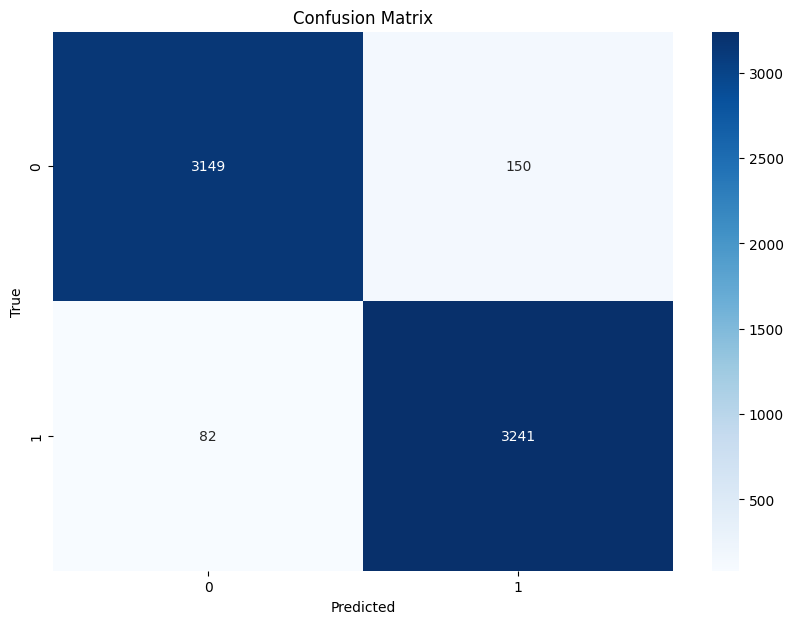

Wrong predictions, true class HAM:
      -----------------------------------     
  Wrong prediction 0: predicted probability  = [4.6301786e-05 9.9995375e-01]
    input: [ 2489  2397  1001  1001  1060  2175  8299  7479  4511  1001  1001 26718
  4012  7276 22956  1035 19400  1035  8816  4511  1001  1001 26718  1019
  1039  3298  1035 19400  1035  3953  1035 19400  1035  3931  8816 11562
  1035 19400  1035  2771  1001  1001  1047  2102  1001  1001  4654  2188
  3931 11562  1035 19400  1035  2771  1001  1001  1047  2102  1001  1001
  4654  1016  1014  1035 19400  1035  8816  1035 19400  1035  1035 19400
  1035 12944 14101  5371  2089  2036  2215  8816  2771  1001  1001  1047
  2102  1001  1001  4654  1016  1014  6410 11135  4895  1001  1001  1062
  2072  1001  1001  1052  1035 19400  1035  1035 19400  1035  5371  1035
 19400  1035  3582  1035 19400  1035  3357 12685  1035 19400  1035  2771
  1001  1001  1047  2102  1001  1001     0     0]
    original sequence: free late # # x go http www

In [ ]:
test_model(model, model_name, test_dataloader, BEST_WEIGHT_PATH, device)

# TensorFlow Conversion and Save
Transfers a PyTorch model to TensorFlow, extracts weights and biases, and saves the model in PB format.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure the directories exist
os.makedirs(MODEL_PATH, exist_ok=True)

# Define model name and paths
model_name = 'distilbert-base-uncased'
best_weight_path = os.path.join(BEST_WEIGHT_PATH, 'weights.pth')

# Load the PyTorch model
pytorch_model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# Load the state dictionary
state_dict = torch.load(best_weight_path, map_location=device)

# Adjust the state dictionary keys
state_dict['classifier.weight'] = state_dict.pop('classifier.2.weight')
state_dict['classifier.bias'] = state_dict.pop('classifier.2.bias')

# Load the modified state dictionary into the model
pytorch_model.load_state_dict(state_dict)

# Extract weights and biases
weights = pytorch_model.classifier.weight.detach().cpu().numpy().T
biases = pytorch_model.classifier.bias.detach().cpu().numpy()

# Load the TensorFlow model
tf_model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=pytorch_model.num_labels)

# Set the weights for the TensorFlow classifier layer
tf_model.classifier.set_weights([weights, biases])

# Save the TensorFlow model in PB format
model_pb_path = os.path.join(MODEL_PATH, 'saved_model')
tf.saved_model.save(tf_model, model_pb_path)

print("Model saved.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g

Model saved.
